# Predicting Hospital Readmission Risk Using Machine Learning

### Background of the project <br>
Unplanned hospital readmissions within 30 days of discharge represent a significant challenge for healthcare systems, contributing to rising costs, operational inefficiencies, and poorer patient outcomes. This white paper presents a machine learning–based approach to predicting 30-day hospital readmission risk using patient demographics, clinical indicators, laboratory results, and treatment-related variables. By identifying high-risk patients before discharge, healthcare providers can implement targeted interventions, improve continuity of care, and reduce preventable readmissions. The proposed solution is designed as a clinical decision support tool that enhances, rather than replaces, clinician judgment while maintaining ethical standards related to privacy, fairness, and transparency.

### Business Problem <br>
Unplanned hospital readmissions impose a substantial financial and operational burden on healthcare organizations. These readmissions often stem from complications following discharge, inadequate follow-up care, medication adherence challenges, or poorly managed chronic conditions. Beyond the direct costs of additional hospital stays, excessive readmission rates expose hospitals to financial penalties from insurers and government programs such as Medicare. From a patient perspective, readmissions are associated with increased morbidity, decreased satisfaction, and diminished quality of life.
The ability to accurately predict which patients are at risk of readmission within 30 days offers an opportunity to address these challenges proactively. Early identification enables clinicians to deploy personalized care plans, strengthen discharge planning, schedule timely follow-ups, and provide additional education or resources. This project aims to develop a robust machine learning model that estimates the probability of 30-day readmission, thereby supporting clinical decision-making and contributing to improved patient outcomes and reduced healthcare costs.

## About the Dataset
This research uses the Diabetes 130-US Hospital Dataset, available from the UCI Machine Learning Repository, in its anonymized form. This dataset contains data from over 100,000 inpatient records spanning ten years from 1999 to 2008 in several U.S. hospitals. Data is also available from an alternative version of this dataset on the Kaggle platform to facilitate ready access and easy replication. This dataset is appropriate for model development for the purpose of predicting the risk of readmission because of its robust size and longitudinal data.

<br><br>
Link to dataset:<br><br>https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008


## 1. Import Libraries

In [5]:


import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")


In [6]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score


## 2. Load and Inspect Data

In [8]:
# Load CSV file
data = pd.read_csv("diabetic_data.csv")

# Quick overview
print(data.shape)
print(data.head())
print(data.info())
print(data.isin(['?']).sum())  # Count of '?' values per column

(101766, 50)
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No        

## 3. Remove unwatned column

In [10]:
data.drop(columns=['encounter_id', 'patient_nbr','payer_code','weight'], inplace=True)
print(data.shape)


(101766, 46)


## 4: Handle missing values

In [12]:
# Replace '?' with np.nan
data.replace('?', np.nan, inplace=True)

# For categorical columns, fill missing values with 'Unknown'
categorical_cols = data.select_dtypes(include='object').columns
data[categorical_cols] = data[categorical_cols].fillna('Unknown')

# For numeric columns, fill missing values with median
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

# Verify
print(data.isnull().sum())


race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazo

In [13]:
print("Shape:", data.shape)

Shape: (101766, 46)


## 5: Exploratory Data Analysis (EDA)

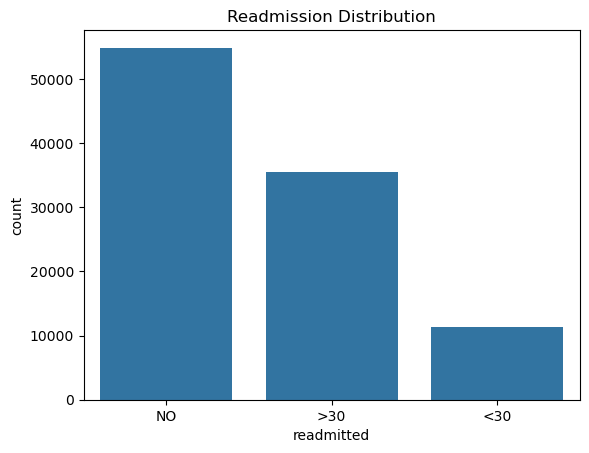

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Target distribution
sns.countplot(x='readmitted', data=data)
plt.title("Readmission Distribution")
plt.show()

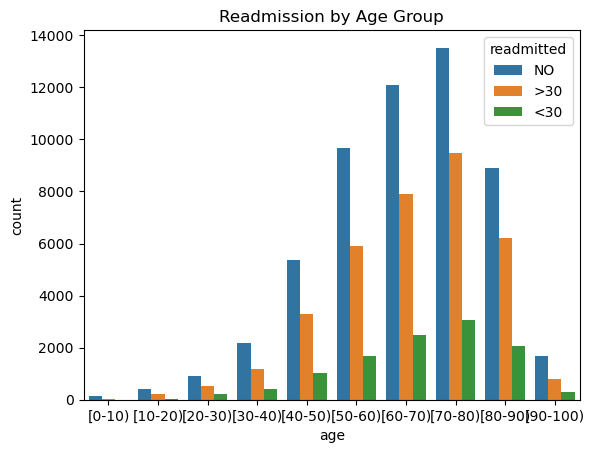

In [20]:
# Readmission by age
sns.countplot(x='age', hue='readmitted', data=data)
plt.title("Readmission by Age Group")
plt.show()


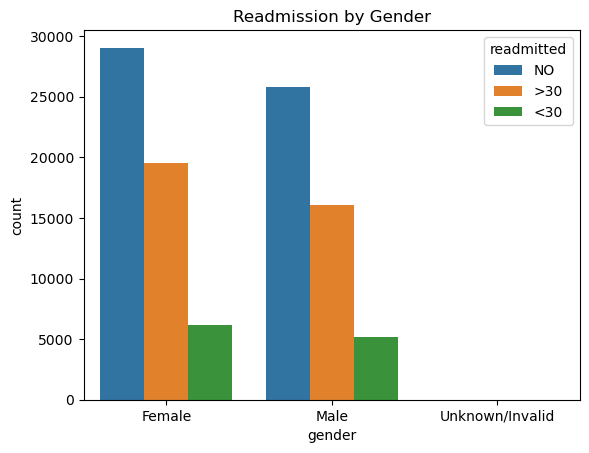

In [21]:

# Readmission by gender
sns.countplot(x='gender', hue='readmitted', data=data)
plt.title("Readmission by Gender")
plt.show()



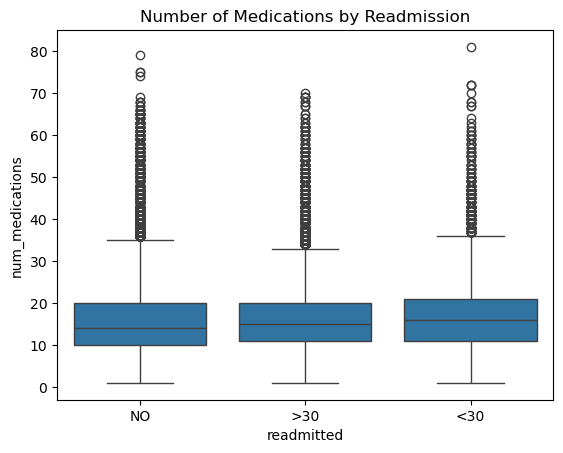

In [22]:
# Number of medications vs Readmission
sns.boxplot(x='readmitted', y='num_medications', data=data)
plt.title("Number of Medications by Readmission")
plt.show()

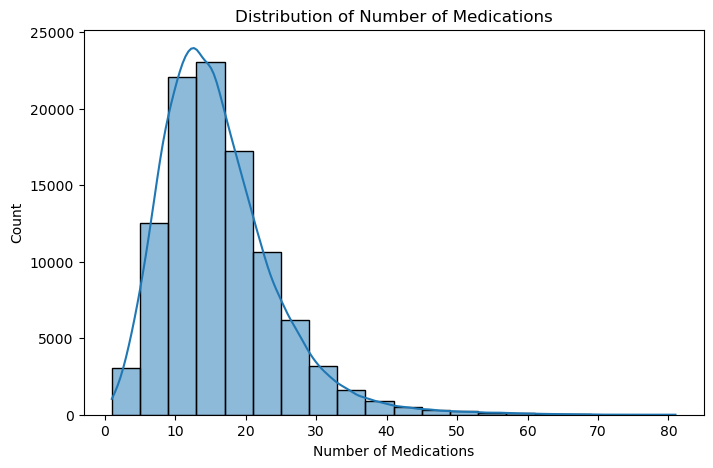

In [23]:
plt.figure(figsize=(8,5))
sns.histplot(data["num_medications"], bins=20, kde=True)
plt.title("Distribution of Number of Medications")
plt.xlabel("Number of Medications")
plt.show()

## 6: Build predictive models

### 6.1 BalancedRandomForestClassifier

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.ensemble import BalancedRandomForestClassifier  # pip install imbalanced-learn
from sklearn.metrics import roc_curve, roc_auc_score


# Save a copy to a new variable
data_balancedrandonclassfier = data.copy()

# Save a copy to a new variable
data_xgboost = data.copy()

# Save a copy to a new variable
data_logisticregression = data.copy()

# Save a copy to a new variable
data_randomforest = data.copy()

In [26]:
# 2. Target variable
data_balancedrandonclassfier['readmitted_binary'] = data_balancedrandonclassfier['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# 3. Feature selection
numeric_features = ['num_lab_procedures','num_medications','time_in_hospital','num_procedures','number_diagnoses']
categorical_features = ['race','gender','age','max_glu_serum','A1Cresult','insulin','change','diabetesMed']

# 4. Preprocessing
# Impute missing values
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
data_balancedrandonclassfier[numeric_features] = num_imputer.fit_transform(data_balancedrandonclassfier[numeric_features])
data_balancedrandonclassfier[categorical_features] = cat_imputer.fit_transform(data_balancedrandonclassfier[categorical_features])

# Encode categorical features
for col in categorical_features:
    data_balancedrandonclassfier[col] = LabelEncoder().fit_transform(data_balancedrandonclassfier[col])

# Scale numeric features
scaler = StandardScaler()
data_balancedrandonclassfier[numeric_features] = scaler.fit_transform(data_balancedrandonclassfier[numeric_features])

# 5. Split data
X = data_balancedrandonclassfier[numeric_features + categorical_features]
y = data_balancedrandonclassfier['readmitted_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_test_balancedrandonclassfier = y_test
# 6. Train Balanced Random Forest
brf_model = BalancedRandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    random_state=42,
    sampling_strategy='auto',  # balances minority class automatically
)
brf_model.fit(X_train, y_train)

# 7. Predict & Evaluate
y_pred = brf_model.predict(X_test)
y_prob = brf_model.predict_proba(X_test)[:,1]

def evaluate_model(y_true, y_pred, y_prob, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 3))
    print("ROC-AUC:", round(roc_auc_score(y_true, y_prob), 3))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

evaluate_model(y_test, y_pred, y_prob, "Balanced Random Forest")

--- Balanced Random Forest ---
Accuracy: 0.505
ROC-AUC: 0.588
Confusion Matrix:
 [[8829 9254]
 [ 831 1440]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.49      0.64     18083
           1       0.13      0.63      0.22      2271

    accuracy                           0.50     20354
   macro avg       0.52      0.56      0.43     20354
weighted avg       0.83      0.50      0.59     20354



In [27]:
# 1. Get predicted probabilities for the positive class
y_pred_proba_brf = brf_model.predict_proba(X_test)[:, 1]
# 2. Compute ROC curves
fpr_brf, tpr_brf, _ = roc_curve(y_test, y_pred_proba_brf)

# 3. Compute AUC
auc_brf = roc_auc_score(y_test, y_pred_proba_brf)

### 6.2 XGboost

In [28]:
import xgboost as xgb  # pip install xgboost
from imblearn.over_sampling import SMOTE  # pip install imbalanced-learn

# 2. Target variable
data_xgboost['readmitted_binary'] = data_xgboost['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# 3. Feature selection
numeric_features = ['num_lab_procedures','num_medications','time_in_hospital','num_procedures','number_diagnoses']
categorical_features = ['race','gender','age','max_glu_serum','A1Cresult','insulin','change','diabetesMed']

# 4. Preprocessing
# Impute missing values
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
data_xgboost[numeric_features] = num_imputer.fit_transform(data_xgboost[numeric_features])
data_xgboost[categorical_features] = cat_imputer.fit_transform(data_xgboost[categorical_features])

# Encode categorical features
for col in categorical_features:
    data_xgboost[col] = LabelEncoder().fit_transform(data_xgboost[col])

# Scale numeric features
scaler = StandardScaler()
data_xgboost[numeric_features] = scaler.fit_transform(data_xgboost[numeric_features])

# 5. Split data
X = data_xgboost[numeric_features + categorical_features]
y = data_xgboost['readmitted_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

y_test_xgboost = y_test

# 6. Apply SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# 7. Train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=1,  # SMOTE handles class balance
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train_bal, y_train_bal)

# 8. Predict and tune threshold
y_prob = xgb_model.predict_proba(X_test)[:,1]

# Default threshold = 0.5
y_pred_default = (y_prob >= 0.5).astype(int)

# Threshold tuning for better recall
# Example: choose threshold that gives recall ~0.7-0.8
threshold = 0.3  # You can experiment with 0.25 - 0.35
y_pred_thresh = (y_prob >= threshold).astype(int)

# 9. Evaluate model
def evaluate_model(y_true, y_pred, y_prob, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 3))
    print("ROC-AUC:", round(roc_auc_score(y_true, y_prob), 3))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

evaluate_model(y_test, y_pred_default, y_prob, "XGBoost Default Threshold (0.5)")
evaluate_model(y_test, y_pred_thresh, y_prob, f"XGBoost Tuned Threshold ({threshold})")

--- XGBoost Default Threshold (0.5) ---
Accuracy: 0.888
ROC-AUC: 0.578
Confusion Matrix:
 [[18071    12]
 [ 2267     4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.25      0.00      0.00      2271

    accuracy                           0.89     20354
   macro avg       0.57      0.50      0.47     20354
weighted avg       0.82      0.89      0.84     20354

--- XGBoost Tuned Threshold (0.3) ---
Accuracy: 0.878
ROC-AUC: 0.578
Confusion Matrix:
 [[17808   275]
 [ 2218    53]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93     18083
           1       0.16      0.02      0.04      2271

    accuracy                           0.88     20354
   macro avg       0.53      0.50      0.49     20354
weighted avg       0.81      0.88      0.83     20354



In [29]:
# 1. Get predicted probabilities for the positive class
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
# 2. Compute ROC curves
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

# 3. Compute AUC
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

### 6.3  Logistic Regression with SMOTE & Random Forest with SMOTE

In [30]:
from imblearn.over_sampling import SMOTE  # pip install imbalanced-learn
# 2. Prepare target variable
data['readmitted_binary'] = data['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# 3. Feature selection
numeric_features = ['num_lab_procedures','num_medications','time_in_hospital','num_procedures','number_diagnoses']
categorical_features = ['race','gender','age','max_glu_serum','A1Cresult','insulin','change','diabetesMed']

# 4. Preprocessing
# Impute missing values
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

data[numeric_features] = num_imputer.fit_transform(data[numeric_features])
data[categorical_features] = cat_imputer.fit_transform(data[categorical_features])

# Encode categorical variables
for col in categorical_features:
    data[col] = LabelEncoder().fit_transform(data[col])

# Scale numeric features
scaler = StandardScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# 5. Split data
X = data[numeric_features + categorical_features]
y = data['readmitted_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6. Apply SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_bal.value_counts())

# 7. Train Models
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_bal, y_train_bal)
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:,1]

# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_bal, y_train_bal)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:,1]

# 8. Evaluate Models
def evaluate_model(y_true, y_pred, y_prob, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_prob))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

evaluate_model(y_test, y_pred_lr, y_prob_lr, "Logistic Regression with SMOTE")
evaluate_model(y_test, y_pred_rf, y_prob_rf, "Random Forest with SMOTE")

Before SMOTE: readmitted_binary
0    72326
1     9086
Name: count, dtype: int64
After SMOTE: readmitted_binary
0    72326
1    72326
Name: count, dtype: int64
--- Logistic Regression with SMOTE ---
Accuracy: 0.5472634371622286
ROC-AUC: 0.5615365305238019
Confusion Matrix:
 [[9923 8160]
 [1055 1216]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.55      0.68     18083
           1       0.13      0.54      0.21      2271

    accuracy                           0.55     20354
   macro avg       0.52      0.54      0.45     20354
weighted avg       0.82      0.55      0.63     20354

--- Random Forest with SMOTE ---
Accuracy: 0.8714257639775965
ROC-AUC: 0.5439247393245876
Confusion Matrix:
 [[17664   419]
 [ 2198    73]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93     18083
           1       0.15      0.03      0.05      2271

    accuracy        

In [31]:
# 1. Get predicted probabilities for the positive class
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# 2. Compute ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)


# 3. Compute AUC
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

### 7 Plot and Compare ROC curves

Logistic Regression AUC: 0.5615
Random Forest AUC: 0.5439
XGBoost AUC: 0.5782
Balanced Random Forest AUC: 0.5879


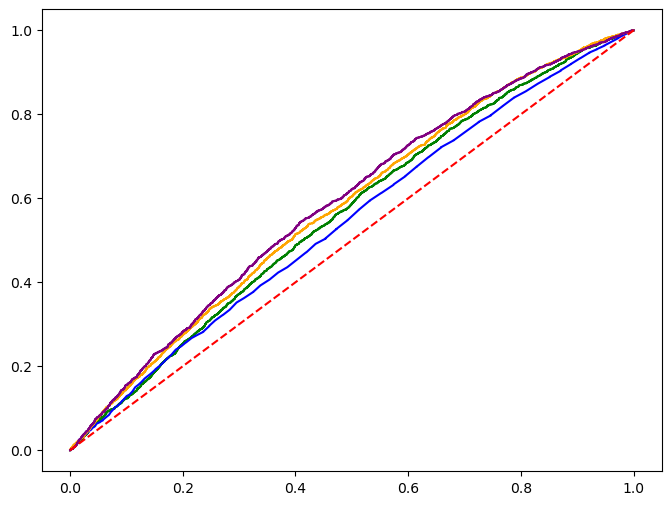

In [32]:
import matplotlib.pyplot as plt


print(f"Logistic Regression AUC: {auc_lr:.4f}")
print(f"Random Forest AUC: {auc_rf:.4f}")
print(f"XGBoost AUC: {auc_xgb:.4f}")
print(f"Balanced Random Forest AUC: {auc_brf:.4f}")
# 4. Plot ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, color='green', label=f'Logistic Regression ROC (AUC = {auc_lr:.4f})')
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'Random Forest ROC (AUC = {auc_rf:.4f})')
plt.plot(fpr_xgb, tpr_xgb, color='orange', label=f'XGBoost ROC (AUC = {auc_xgb:.4f})')
plt.plot(fpr_brf, tpr_brf, color='purple', label=f'Balanced Random Forest ROC (AUC = {auc_brf:.4f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')

As it is clear from the ROC curve, the Balanced Random Forest has the highest power of distinguishing between the patients who will and will will not be readmitted, although none of the classifiers have good discriminatory power. This suggests that although it is difficult to forecast patient readmission using these variables, using the Balanced Random Forest classifier helps in getting the best classification results using these variables.

### 8 Calculate Feature Importance for Balanced Random Forest 

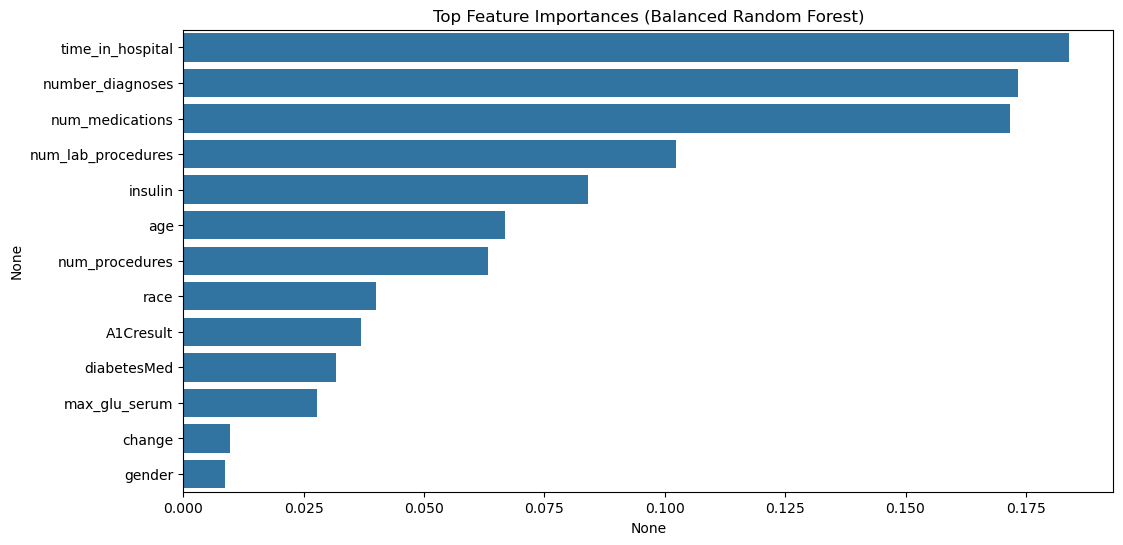

In [33]:
# Balanced Random Forest Feature Importance
import seaborn as sns

importances = brf_model.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=feat_imp[:15], y=feat_imp.index[:15])
plt.title("Top Feature Importances (Balanced Random Forest)")
plt.show()

### 9 Comparison of Models Based on Recall for Readmission

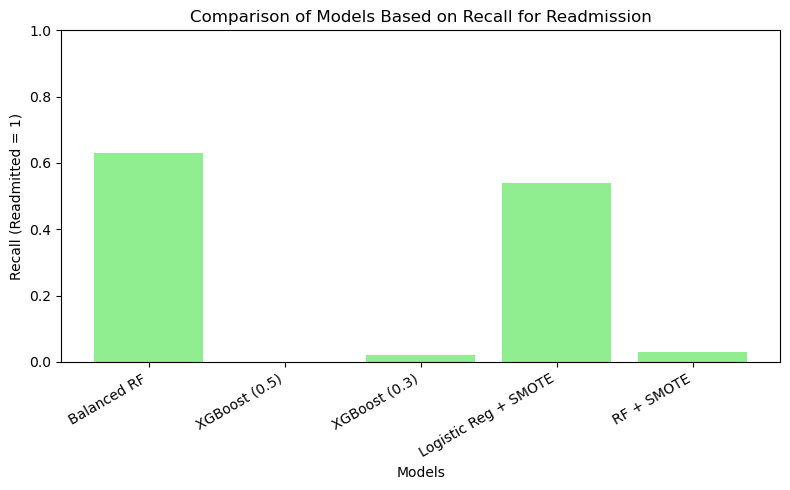

In [34]:
import matplotlib.pyplot as plt

models = [
    "Balanced RF",
    "XGBoost (0.5)",
    "XGBoost (0.3)",
    "Logistic Reg + SMOTE",
    "RF + SMOTE"
]

recall_class1 = [0.63, 0.00, 0.02, 0.54, 0.03]

plt.figure(figsize=(8,5))
plt.bar(models, recall_class1, color='lightgreen')
plt.xlabel("Models")
plt.ylabel("Recall (Readmitted = 1)")
plt.title("Comparison of Models Based on Recall for Readmission")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


### 10 Conclusion

The experiment made use of several machine learning models in predicting readmission within 30 days to a hospital using an imbalanced clinical dataset. Accuracy, ROC AUC, confusion matrix, and class-specific precision, recall, and F1-measures were used to assess the performance of the models, focusing on the readmitted class. <br><br>

As can be deduced from the results, it is clear that relying purely on accuracy for decision-making would not have been appropriate here. This is due to the fact that methods like XGBoost and Random Forest with the help of SMOTE have yielded high accuracy, which is around 87% and 89%, respectively, while having poor recall, particularly for the group of patients who were actually readmitted, meaning that most of the actual readmitted cases were not identified. <br><br>

A Standard Random Forest (RF) learns decision trees from random bootstrap samples of the dataset, resulting in a tendency towards majority class bias in imbalanced datasets, while a Balanced Random Forest (BRF) does it in a way that it undersamples the majority class in a bootstrap sample such that the number of samples in the minority class in that sample equals the size of the majority class. This ensures that every decision tree gets a balanced view of the dataset. <br>
In contrast, the Balanced Random Forest model achieved the highest recall (63%) and the best F1-score for the readmitted class, along with the highest ROC-AUC (0.588). Although its overall accuracy was lower, this model was most effective at identifying patients at risk of readmission, making it the most appropriate choice for healthcare applications focused on early intervention and patient safety.
<br><br>
The Logistic Regression model with SMOTE also performed reasonably well, achieving a recall of 54% for readmissions. While its performance was slightly inferior to the Balanced Random Forest, it provides a more interpretable alternative and serves as a strong baseline model.<br><br>

Overall, the findings indicate that models specifically designed to handle class imbalance outperform standard classifiers for readmission prediction. The Balanced Random Forest is the recommended model for this task, as it best balances sensitivity to readmissions with overall predictive performance. Future improvements may include feature engineering, cost-sensitive learning, and optimization using precision-recall metrics to further enhance minority-class detection.<br><br>

Overall, the results suggest that the imbalance models perform better than the conventional classifiers. The model that works best for readmission is the Balanced Random Forest. This model performs well with respect to its sensitivity for readmission and the overall performance. Future works may involve feature engineering, cost-sensitive learning, or optimizing for the precision-recall curve.<br><br>